<a href="https://colab.research.google.com/github/LeviJunior21/AnaliseTecnicaAlgoritmos/blob/master/Trabalho_da_Disciplina_de_CDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Título do Projeto: Sistema de Identificação das doenças baseada nos sintomas
### Estudante: Levi de Lima Pereira Júnior
### Matŕicula: 121210472

## Imports

Datasets:

- Link 1: https://www.kaggle.com/datasets/harivatsaga/disease-prediction
- Link 3: https://drive.google.com/file/d/17UhRvLyVuJgznFuZ2MlollPV8RaGndjs/view

In [ ]:
%%capture
!pip install transformers datasets torch
!pip install sacremosesv
!pip install sacremoses
!pip install contractions

import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import requests
from bs4 import BeautifulSoup
import torch
from transformers import BioGptForCausalLM, BioGptTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset

import nltk.corpus
from nltk                             import pos_tag, SnowballStemmer
from nltk.tokenize                    import word_tokenize

from nltk.corpus import wordnet
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

import numpy as np
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.model_selection          import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import contractions
lemmatizer = nltk.stem.WordNetLemmatizer()
param_stemmer = SnowballStemmer('english')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

## Importando os Dados

In [ ]:
"""
Tucker, Jay (2024). “SymbiPredict”. Mendeley Data, V1. Disponível em: <https://data.mendeley.com/datasets/dv5z3v2xyd/1>

4961 entradas, 41 doenças distintas, 121 entradas por doenças.
Associa a presença ou a ausência de 132 sintomas a um determinado prognóstico médico.
"""
data_one = pd.read_csv("https://drive.google.com/uc?export=download&id=17UhRvLyVuJgznFuZ2MlollPV8RaGndjs")
data_one

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal Infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vertigo
4957,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,Acne
4958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Urinary Tract Infection
4959,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,Psoriasis


In [ ]:
"""
Barman , Niyar (2022). Symptom2Disease. Kaggle. Disponível em: <https://www.kaggle.com/datasets/niyarrbarman/symptom2disease/discussion?sort=undefined>

1200 entradas, 24 doenças distintas, 50 entradas por doença.
Para cada doença, associa uma descrição dos sintomass, em linguagem natural e primeira pessoa.

Ex: "Doutor, minha pele está coberta por uma erupção muito desconfortável,
    junto com algumas manchas estranhas de um tom diferente. Minha pele
    também tem algumas espinhas que lembram pequenos nós"
    >>>> INFECÇÃO FÚNGICA

    "Mesmo quando não tenho nada ácido no estômago, sinto constantemente
    um gosto amargo na boca. Freqüentemente tenho um nó na garganta e
    soluços.
    >>>> DOENÇA DO REFLUXO GASTROESOFÁGICO"
"""
data_three = pd.read_csv("https://drive.google.com/uc?export=download&id=1yyD_6vwPY9p-AlHYxJO3JNkbxXYuKrQr")
data_three

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...,...
1195,295,diabetes,I'm shaking and trembling all over. I've lost ...
1196,296,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,297,diabetes,I regularly experience these intense urges and...
1198,298,diabetes,"I have trouble breathing, especially outside. ..."


## Formatação dos Dados

In [ ]:
"""
Tirando ruido das frases para ajudar na stemmização e lematização.
"""
def clean_label(label):
    if label == 'dimorphic hemmorhoids (piles)':
        label = 'dimorphic hemorrhoids'
    if label == 'bronchial asthma':
        label = 'asthma'
    if label == 'peptic ulcer disease':
        label = 'peptic ulcer'
    return label

data_one = data_one.rename(columns={'prognosis': 'label'})
data_one['label'] = data_one['label'].str.lower().str.strip()
symptom_columns = data_one.columns[:-1]
data_one['symptoms'] = data_one[symptom_columns].apply(
    lambda row: ', '.join([col for col, val in row.items() if val == 1]), axis=1
)
data_one = data_one[['label', 'symptoms']]
data_one['label'] = data_one['label'].apply(clean_label)
data_one

<ipython-input-4-e021c1841fa9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one['label'] = data_one['label'].apply(clean_label)


,label,symptoms
0,fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _p..."
2,fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,fungal infection,"itching, skin_rash, dischromic _patches"
4,fungal infection,"itching, skin_rash, nodal_skin_eruptions"
...,...,...
4956,vertigo,"vomiting, headache, nausea, spinning_movements..."
4957,acne,"skin_rash, pus_filled_pimples, blackheads, scu..."
4958,urinary tract infection,"burning_micturition, bladder_discomfort, foul_..."
4959,psoriasis,"skin_rash, joint_pain, skin_peeling, silver_li..."


In [ ]:
def clean_label(label):
  if label == 'chicken pox':
    label = 'chickenpox'
  if label == 'bronchial asthma':
    label = 'asthma'

  label = re.sub(r'disease', '', label, flags=re.IGNORECASE)
  label = re.sub(r"'s\s", '', label)
  label = re.sub(r'\(.*?\)', '', label)
  label = re.sub(r'\(.*', '', label)
  label = re.sub(r'\.\.\.', '', label)
  label = label.strip()

  return label

data_three = data_three.drop('Unnamed: 0', axis=1)
data_three = data_three.rename(columns={'text': 'symptoms'})
data_three['label'] = data_three['label'].str.lower()
data_three['label'] = data_three['label'].str.strip()
data_three['label'] = data_three['label'].apply(clean_label)
data_three

,label,symptoms
0,psoriasis,I have been experiencing a skin rash on my arm...
1,psoriasis,"My skin has been peeling, especially on my kne..."
2,psoriasis,I have been experiencing joint pain in my fing...
3,psoriasis,"There is a silver like dusting on my skin, esp..."
4,psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


In [ ]:
df = pd.concat([data_one, data_three], ignore_index=True)
df

,label,symptoms
0,fungal infection,"itching, skin_rash, nodal_skin_eruptions, disc..."
1,fungal infection,"skin_rash, nodal_skin_eruptions, dischromic _p..."
2,fungal infection,"itching, nodal_skin_eruptions, dischromic _pat..."
3,fungal infection,"itching, skin_rash, dischromic _patches"
4,fungal infection,"itching, skin_rash, nodal_skin_eruptions"
...,...,...
6156,diabetes,I'm shaking and trembling all over. I've lost ...
6157,diabetes,"Particularly in the crevices of my skin, I hav..."
6158,diabetes,I regularly experience these intense urges and...
6159,diabetes,"I have trouble breathing, especially outside. ..."


## Pré-Processamento

In [ ]:
def remove_palavras_pequenas_grandes(tokens):
  return [token for token in tokens if len(token) > 2 and len(token) < 16]

def remove_stopwords(tokens):
  liststopwords = nltk.corpus.stopwords.words('english')
  return [token for token in tokens if token not in liststopwords]

def stemming(tokens, stemmer):
  return [stemmer.stem(token) for token in tokens]

def corrigir_documento(document):
  return contractions.fix()

def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

def lemmatize(tokens):
  lemmatized_tokens = []
  pos_tagged = pos_tag(tokens)
  for token, tag in pos_tagged:
    wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN
    lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))

  return lemmatized_tokens

In [ ]:
"""
Eliminando palavras grandes e pequenas e aplicando lematização para converter as palavras que derivam do seu mesmo radical para o radical e fazendo stemming das palavras porque existem palavras que não tem radical pego pela lematização, então resolvi remover as derivações das palavras da lematização.
"""
def process_corpus(corpus):
  corpus_processed = []
  for document in corpus:
    tokens = word_tokenize(document)
    tokens = remove_palavras_pequenas_grandes(tokens)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize(tokens)
    tokens = stemming(tokens, param_stemmer)
    corpus_processed.append(" ".join(tokens))
  return corpus_processed

corpus = df['symptoms'].tolist()
corpus_processed = process_corpus(corpus)

## Treinamento

In [ ]:
# Separando dados de treino e teste para fazer a validação cruzada
x_treino, x_teste, y_treino, y_teste = train_test_split(corpus_processed, df['label'], test_size=0.2, shuffle=True)

# Removendo palavras com ocorrencias superiores a 95%.
vetorizador = TfidfVectorizer(max_df=0.95, min_df=1, ngram_range=(1,3), max_features=None)

In [ ]:
# Convertendo as palavras em uma matriz númerica para os dados de treino e teste
x_treino_vetorizado = vetorizador.fit_transform(x_treino)
x_teste_vetorizado = vetorizador.transform(x_teste)

In [ ]:
modelo_RegressaoLogistica = LogisticRegression()
modelo_RegressaoLogistica.fit(x_treino_vetorizado, y_treino)
predicao_RegressaoLogistica = modelo_RegressaoLogistica.predict(x_teste_vetorizado)

## Precisão/Acurácia

In [ ]:
accuracy = accuracy_score(y_teste, predicao_RegressaoLogistica)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.98


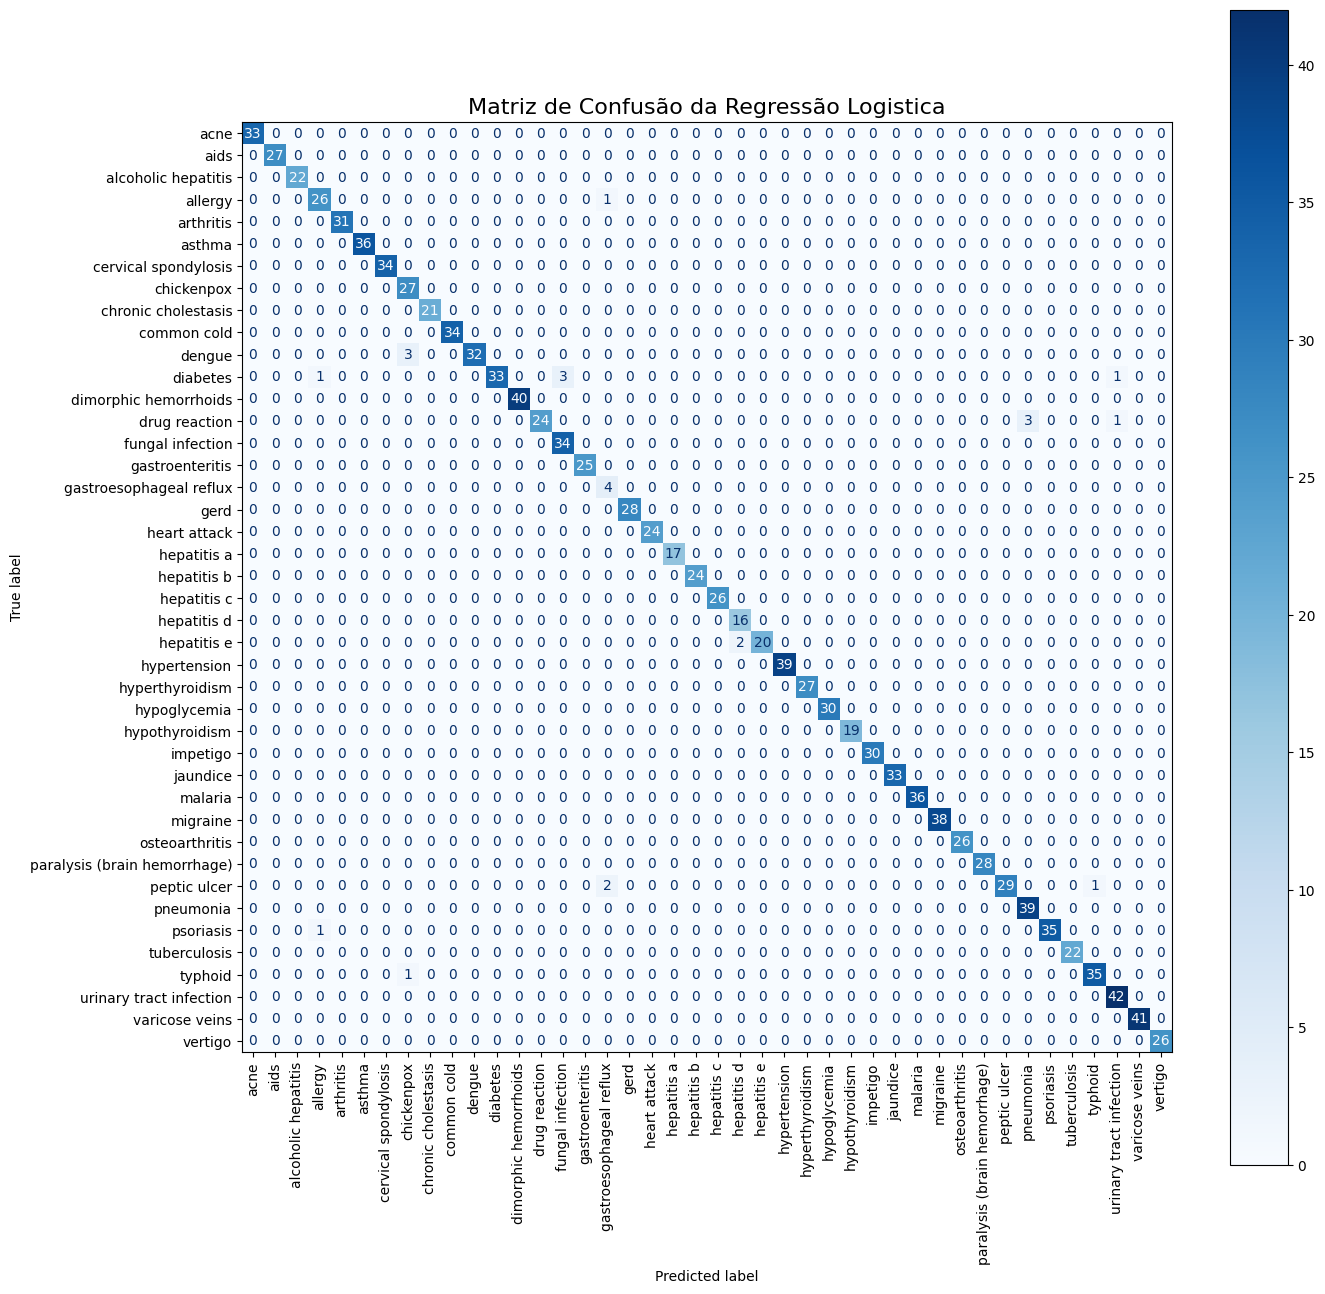

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, classification_report
import matplotlib.pyplot as plt

predicao_RegressaoLogistica = modelo_RegressaoLogistica.predict(x_teste_vetorizado)

matriz_confusao = confusion_matrix(y_teste, predicao_RegressaoLogistica)

labels = sorted(set(y_teste) | set(predicao_RegressaoLogistica))

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Matriz de Confusão da Regressão Logistica", fontsize=16)
plt.show()

# Comentários sobre a Matriz de Confusão
- A infecção urinária está sendo confudido com reação a drogas.
# Relatório

In [ ]:
relatorio = classification_report(y_teste, predicao_RegressaoLogistica, target_names=labels)
print(relatorio)

                              precision    recall  f1-score   support

                        acne       1.00      1.00      1.00        33
                        aids       1.00      1.00      1.00        27
         alcoholic hepatitis       1.00      1.00      1.00        22
                     allergy       0.93      0.96      0.95        27
                   arthritis       1.00      1.00      1.00        31
                      asthma       1.00      1.00      1.00        36
        cervical spondylosis       1.00      1.00      1.00        34
                  chickenpox       0.87      1.00      0.93        27
         chronic cholestasis       1.00      1.00      1.00        21
                 common cold       1.00      1.00      1.00        34
                      dengue       1.00      0.91      0.96        35
                    diabetes       1.00      0.87      0.93        38
       dimorphic hemorrhoids       1.00      1.00      1.00        40
               drug

## Exemplos

In [ ]:
"""
Tratando o texto de entrada do usuário a partir da função process_corpus.
"""
def processa_entrada(vetorizador, classificador, entrada, top_n):
  resultado = ""

  processed_input = entrada.strip().lower().split()
  processed_input = process_corpus(processed_input)
  processed_input = [word for word in processed_input if word != '']
  processed_input = ' '.join(processed_input)

  if (processed_input != ""):
    corpus_processados = process_corpus([processed_input])
    predicao_y = vetorizador.transform(corpus_processados)

    probas = classificador.predict_proba(predicao_y)[0]

    classes = classificador.classes_

    class_proba = list(zip(classes, probas))

    resultado = sorted(class_proba, key=lambda x: x[1], reverse=True)[:top_n]

  return resultado

In [ ]:
# Exemplo de uso para sintomas de DENGUE
# O paciente apresenta febre alta (até 38,5°C), dor de cabeça intensa de início súbito, dores musculares e articulares intensas, mal-estar geral, náuseas e vômitos, manchas vermelhas no corpo, dores musculares e perda de apetite
input_text = """
The patient presents with high fever (up to 38.5°C), sudden onset severe headache, severe muscle and joint pain, general malaise, nausea and vomiting, red spots on the body, muscle pain, and loss of appetite
"""

resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 1)

for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Classe: dengue, Probabilidade: 16.1679%


In [ ]:
# Exemplo de uso para sintomas de DIABETES:
#Estão presentes fome e sede excessivas, micção frequente, perda de peso inexplicável, fraqueza e fadiga, alterações de humor, náuseas e vômitos, boca seca, alterações na visão, formigamento nos pés e nas mãos e infecções frequentes na bexiga, rins e pele.
input_text = """
Excessive hunger and thirst, frequent urination, unexplained weight loss, weakness and fatigue, mood swings, nausea and vomiting, dry mouth, vision changes, tingling in the feet and hands,
and frequent infections in the bladder, kidneys, and skin are present.
"""

resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 1)

for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Classe: diabetes, Probabilidade: 12.3538%


In [ ]:
# Exemplo de uso para sintomas de VEIAS VARICOSAS:
# Dor e sensação de peso nas pernas, especialmente no final do dia, juntamente com inchaço nas pernas, tornozelos e pés que pode piorar à noite. Coceira ao redor das veias varicosas, cãibras nas pernas, especialmente à noite, alterações na cor da pele ao redor dos tornozelos e pernas, como escurecimento ou vermelhidão, veias varicosas visíveis e torcidas e, em casos mais graves, feridas difíceis de curar, geralmente ao redor do tornozelo interno.
input_text = """
Pain and a feeling of heaviness in the legs, especially at the end of the day, along with swelling in the legs, ankles, and feet that may worsen by evening. Itching around varicose veins, leg cramps, particularly at night,
changes in skin color around the ankles and legs such as darkening or reddening, visible and twisted varicose veins, and in more severe cases, hard-to-heal sores, usually around the inner ankle.
"""

resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 1)

for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Classe: varicose veins, Probabilidade: 24.4831%


In [ ]:
# Exemplo de uso para sintomas de PNEUMONIA:
# Tenho tido dificuldade para respirar, com uma tosse que produz muco. Também sinto dor no peito, especialmente quando respiro fundo ou tusso. Tenho tido febre, calafrios e tenho me sentido anormalmente cansado e fraco. Às vezes, fico sem fôlego mesmo quando faço atividades leves.
input_text = """
  I've been having trouble breathing, with a cough that produces mucus. I also feel chest pain, especially when I breathe deeply or cough. I’ve had a fever, chills, and I’ve been
  feeling unusually tired and weak. Sometimes, I get short of breath even when doing light activities.
"""

resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)

print("Top 4 resultados e probabilidades:")
for label, prob in resultadoRegressaoLogistica:
    print(f"Classe: {label}, Probabilidade: {(prob*100):.4f}%")

Top 4 resultados e probabilidades:
Classe: asthma, Probabilidade: 13.8739%
Classe: pneumonia, Probabilidade: 10.8195%
Classe: allergy, Probabilidade: 8.6066%
Classe: gastroesophageal reflux, Probabilidade: 4.7420%


In [ ]:
def formatar_saida(resultados, numero_de_resultados=4):
    print("\nOlá! Com base nos sintomas que você descreveu, aqui estão algumas doenças que podem estar relacionadas:")
    print(f"Top {numero_de_resultados} resultados e probabilidades:\n")

    for i, (label, prob) in enumerate(resultados):
        print(f"{i + 1}. Possível doença: {label}, Probabilidade: {(prob*100):.2f}%")

    print("\nImportante: Isso é apenas uma estimativa e não substitui uma consulta com um profissional de saúde.")
    print("Se você estiver preocupado com seus sintomas, recomendamos que procure orientação médica.")

# Remova esse comentário abaixo para testar o modelo via regressão logistica a partir de um texto de sintomas em inglês.
"""
def main():
    input_text = input("Por favor, insira uma descrição dos seus sintomas (ex: sede excessiva, fadiga, perda de peso): ")
    resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)
    formatar_saida(resultadoRegressaoLogistica)

if __name__ == "__main__":
    main()
"""

'\ndef main():\n    input_text = input("Por favor, insira uma descrição dos seus sintomas (ex: sede excessiva, fadiga, perda de peso): ")\n    resultadoRegressaoLogistica = processa_entrada(vetorizador, modelo_RegressaoLogistica, input_text, 4)\n    formatar_saida(resultadoRegressaoLogistica)\n\nif __name__ == "__main__":\n    main()\n'

# Árvore de Decisão

In [ ]:
smote = SMOTE(random_state=42)

X = corpus_processed
y = df['label']

vectorizer_tree = CountVectorizer()
X_transformed_tree = vectorizer_tree.fit_transform(X)

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_transformed_tree, y, test_size=0.2, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tree, y_train_tree)

model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train_balanced, y_train_balanced)

y_pred_tree = model_tree.predict(X_test_tree)

accuracy_tree = accuracy_score(y_test_tree, y_pred_tree)
print(f'Accuracy: {accuracy_tree * 100:.2f}%')

labels_tree = sorted(set(y_test_tree) | set(y_pred_tree))
relatorio_tree = classification_report(y_test_tree, y_pred_tree, target_names=labels_tree)
print(relatorio_tree)

Accuracy: 95.62%
                              precision    recall  f1-score   support

                        acne       1.00      1.00      1.00        34
                        aids       1.00      1.00      1.00        27
         alcoholic hepatitis       1.00      0.96      0.98        26
                     allergy       0.97      0.89      0.93        38
                   arthritis       1.00      1.00      1.00        31
                      asthma       0.89      1.00      0.94        34
        cervical spondylosis       1.00      0.95      0.98        43
                  chickenpox       0.84      0.84      0.84        38
         chronic cholestasis       1.00      1.00      1.00        25
                 common cold       0.88      0.91      0.89        32
                      dengue       0.78      0.81      0.79        31
                    diabetes       0.93      0.87      0.90        31
       dimorphic hemorrhoids       0.93      1.00      0.96        38
  

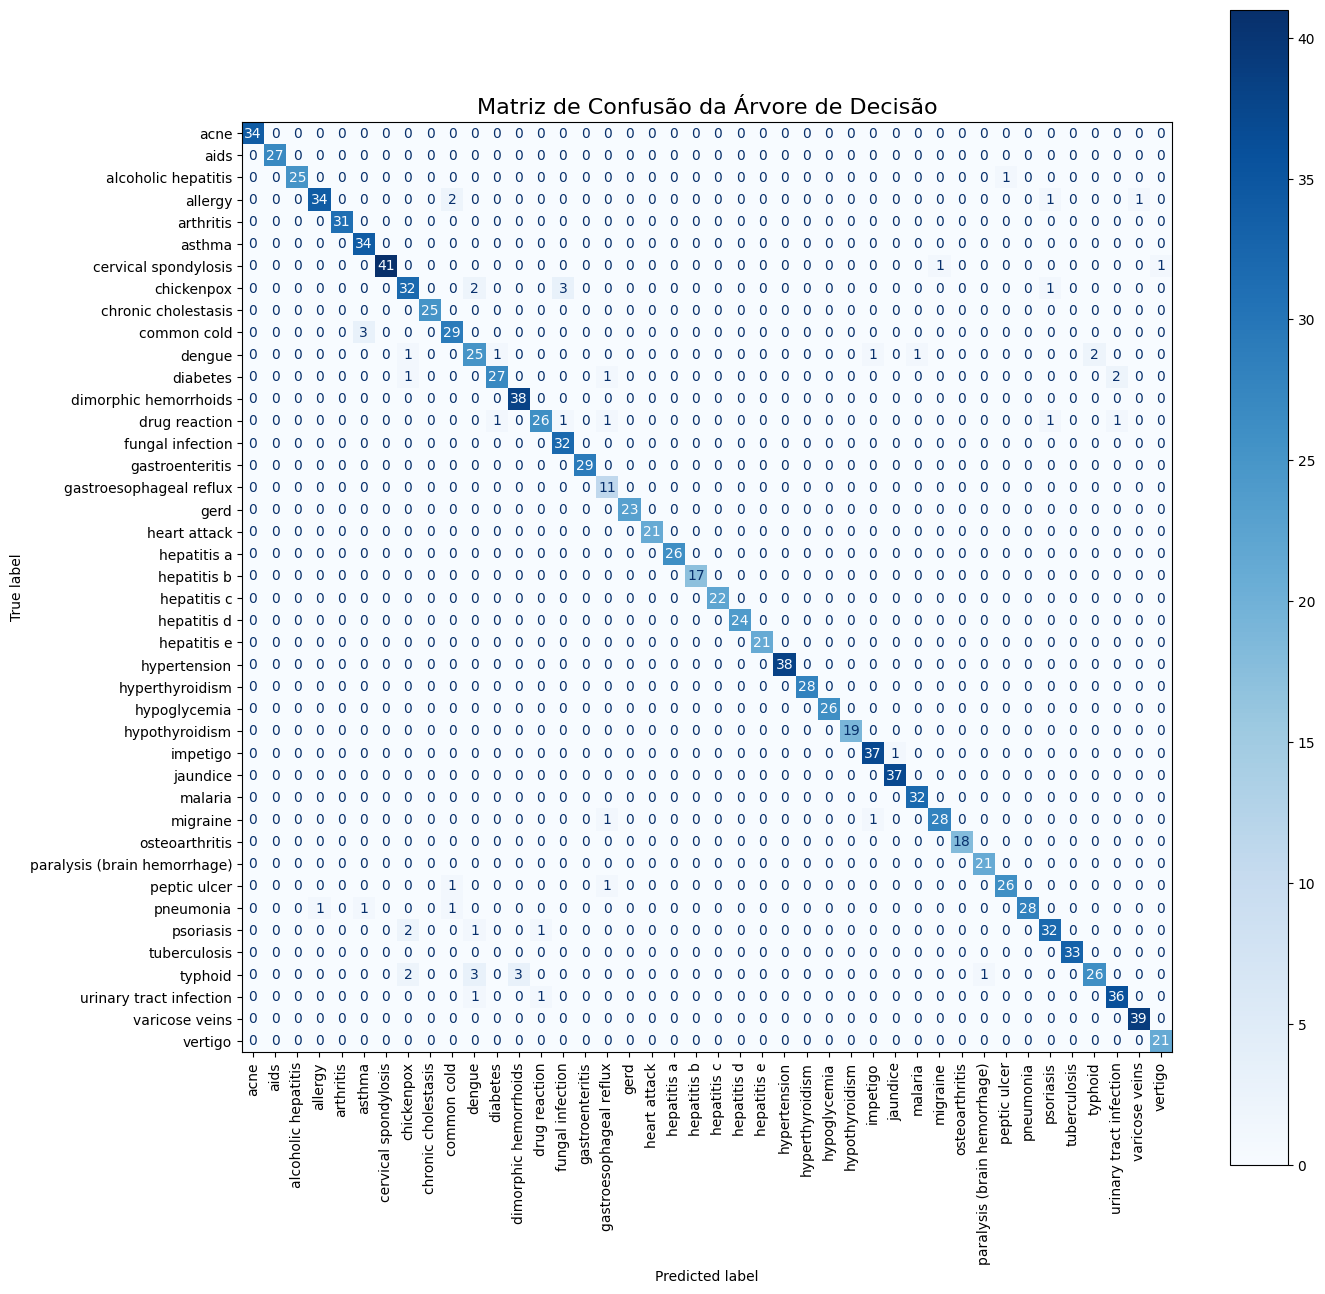

In [ ]:
matriz_confusao = confusion_matrix(y_test_tree, y_pred_tree)

labels = sorted(set(y_test_tree) | set(y_pred_tree))

fig, ax = plt.subplots(figsize=(15, 15))

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Matriz de Confusão da Árvore de Decisão", fontsize=16)
plt.show()

In [ ]:
# Exemplo de uso para sintomas de VEIAS VARICOSAS:
# Dor e sensação de peso nas pernas, especialmente no final do dia, juntamente com inchaço nas pernas, tornozelos e pés que pode piorar à noite. Coceira ao redor das veias varicosas, cãibras nas pernas, especialmente à noite, alterações na cor da pele ao redor dos tornozelos e pernas, como escurecimento ou vermelhidão, veias varicosas visíveis e torcidas e, em casos mais graves, feridas difíceis de curar, geralmente ao redor do tornozelo interno.
input_text = """
Pain and a feeling of heaviness in the legs, especially at the end of the day, along with swelling in the legs, ankles, and feet that may worsen by evening. Itching around varicose veins, leg cramps, particularly at night,
changes in skin color around the ankles and legs such as darkening or reddening, visible and twisted varicose veins, and in more severe cases, hard-to-heal sores, usually around the inner ankle.
"""

label, prob = processa_entrada(vectorizer_tree, model_tree, input_text, 1)[0]

print(f"Classe: {label}, Probabilidade: {(prob*100):.2f}%")

Classe: varicose veins, Probabilidade: 100.00%


In [ ]:
from sklearn.ensemble import VotingClassifier

# Criando os modelos base
modelo_RegressaoLogistica = LogisticRegression()
modelo_ArvoreDecisao = DecisionTreeClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', modelo_RegressaoLogistica),
        ('dt', modelo_ArvoreDecisao)
    ],
    voting='soft'
)

voting_clf.fit(X_train_balanced, y_train_balanced)

y_pred_voting = voting_clf.predict(X_test_tree)
accuracy_voting = accuracy_score(y_test_tree, y_pred_voting)

print(f"Acurácia do Voting Classifier: {accuracy_voting * 100:.2f}%")
print(classification_report(y_test_tree, y_pred_voting))


Acurácia do Voting Classifier: 95.62%
                              precision    recall  f1-score   support

                        acne       1.00      1.00      1.00        34
                        aids       1.00      1.00      1.00        27
         alcoholic hepatitis       1.00      0.96      0.98        26
                     allergy       0.97      0.89      0.93        38
                   arthritis       1.00      1.00      1.00        31
                      asthma       0.89      1.00      0.94        34
        cervical spondylosis       1.00      0.95      0.98        43
                  chickenpox       0.84      0.84      0.84        38
         chronic cholestasis       1.00      1.00      1.00        25
                 common cold       0.88      0.91      0.89        32
                      dengue       0.78      0.81      0.79        31
                    diabetes       0.93      0.87      0.90        31
       dimorphic hemorrhoids       0.93      1.00  

# **Ensembles**

# Bagging

In [ ]:
import numpy as np
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_balanced_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_tree_encoded = label_encoder.transform(y_test_tree)

# BAGGING - Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced_encoded)
y_pred_rf = rf_model.predict(X_test_tree)
accuracy_rf = accuracy_score(y_test_tree_encoded, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf * 100:.2f}%')

# BOOSTING - Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced_encoded)
y_pred_gb = gb_model.predict(X_test_tree)
accuracy_gb = accuracy_score(y_test_tree_encoded, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb * 100:.2f}%')

# BOOSTING - XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced_encoded)
y_pred_xgb = xgb_model.predict(X_test_tree)
accuracy_xgb = accuracy_score(y_test_tree_encoded, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb * 100:.2f}%')

# STACKING - Combinação de Reg Logística, Árvore de Decisão e Florestas Aleatórias
modelo_RegressaoLogistica = LogisticRegression(max_iter=200, random_state=42)
stacking_model = StackingClassifier(
    estimators=[
        ('logistic_regression', modelo_RegressaoLogistica),
        ('decision_tree', model_tree),
        ('random_forest', rf_model),
        ('gradient_boosting', rf_model),
        ('xgboost', xgb_model)
    ],
    final_estimator=GradientBoostingClassifier(n_estimators=50, random_state=42)
)
stacking_model.fit(X_train_balanced, y_train_balanced_encoded)
y_pred_stacking = stacking_model.predict(X_test_tree)
accuracy_stacking = accuracy_score(y_test_tree_encoded, y_pred_stacking)
print(f'Acurácia do Stacking: {accuracy_stacking * 100:.2f}%')

Random Forest Accuracy: 97.73%
Gradient Boosting Accuracy: 97.00%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:47:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 97.97%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:48:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Acurácia do Stacking: 98.86%


In [ ]:
import pandas as pd

resultados = {
    "Modelo": ["Regressão Logistica", "Árvore de Decisão", "Random Forest", "Gradient Boosting", "XGBoost", "Stacking"],
    "Tipo": ["Base", "Base", "Bagging", "Boosting", "Boosting", "Ensemble"],
    "Acurácia (%)": [
        accuracy * 100,
        accuracy_tree * 100,
        accuracy_rf * 100,
        accuracy_gb * 100,
        accuracy_xgb * 100,
        accuracy_stacking * 100
    ],
    "Interpretabilidade": [
        "Baixo", "Muito baixo", "Médio", "Alto", "Médio", "Alto"
    ],
    "Robustez": [
        "Média", "Baixa", "Alta", "Alta", "Alta", "Alta"
    ]
}

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


                Modelo      Tipo  Acurácia (%) Interpretabilidade Robustez
0  Regressão Logistica      Base     98.377940              Baixo    Média
1    Árvore de Decisão      Base     95.620438        Muito baixo    Baixa
2        Random Forest   Bagging     97.729116              Médio     Alta
3    Gradient Boosting  Boosting     96.999189               Alto     Alta
4              XGBoost  Boosting     97.972425              Médio     Alta
5             Stacking  Ensemble     98.864558               Alto     Alta


# Melhor Modelo e Abordagem
### Melhor desempenho: Stacking, com 98.86% de acurácia.

- Nas aulas vimos que o Stacking combina diferentes algoritmos (por exemplo, uma floresta com uma regressão logística) e utiliza um "meta-modelo" para melhorar a performance. Com isso, ele é capaz de capturar relações que os modelos individuais não detectam. Isso geralmente resulta em maior generalização e redução de erros.

# Overfitting ou Underfitting
- O Stacking e Regressão Logística apresentam ótimos resultados, e considerando que a diferença entre treino e teste não é alta e não há sinais claros de overfitting.
- A Árvore de Decisão teve a menor acurácia, o que pode indicar o underfitting e ela talvez não esteja capturando toda a complexidade dos dados.

# Interpretabilidade
- Mais interpretável: A Regressão Logística e Árvore de Decisão são os modelos mais transparentes, pois é possível entender diretamente como os sintomas influenciam na previsão.

- Menos interpretável: O XGBoost, Gradient Boosting e o Stacking são mais interessantes, mas também menos explicáveis, o que pode ser um problema em domínios sensíveis como saúde porque ele combina modelos e isso torna mais difícil de ser explicado. Pois, pelo que vi nas aulas, o modelo seguinte aprende a explicar coisas que o modelo anterior não conseguiu aprender.

# Aplicações e Possíveis maus Usos
### Usos válidos:
- Entendo que um dos usos válidos para ele seria sobre o auxílio no diagnóstico preliminar em sistemas médicos para ajudar os médicos ou enfermeiros a ter um diagnóstico prévio do paciente.

-  o nível de urgência do paciente baseado nos sintomas. Se a recepcionista ou na triagem identificar que aquela doença que foi predita é precisa de maior urgência nos hospitais ou postos de saúde.

- Triagem inicial em chatbots de saúde.

- Suporte à decisão para profissionais da saúde.

### Riscos ou maus usos:
- Utilização sem supervisão médica, levando a autodiagnóstico incorreto.

- Falta de explicabilidade, dificultando a confiança no sistema.

- Viés de dados: se o modelo foi treinado com dados desbalanceados, pode prejudicar grupos específicos.